# Visualization of Label Smoothing

## Imports and data loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import torch
import torch.nn as nn
import jupyter_black
from torchsummary import summary
from sklearn.decomposition import PCA
import random
import torch.utils.data as data
import torch.nn.functional as F
from tqdm import tqdm

from data_generators import data_loader_MNIST, data_loader_CIFAR10_32_32, data_loader_CIFAR100_32_32
from model_classes import LeNet, LeNet_100
from tools import accuracy, plot_results, plot_reg_results, svb

jupyter_black.load()

C:\Users\aslak\.conda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Loading datasets

# Loading MNIST dataset
train_loader_MNIST, test_loader_MNIST = data_loader_MNIST()

# Loading CIFAR10 dataset
train_loader_CIFAR10, test_loader_CIFAR10 = data_loader_CIFAR10_32_32()

# Loading CIFAR100 dataset
train_loader_CIFAR100, test_loader_CIFAR100 = data_loader_CIFAR100_32_32()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Train function

In [4]:
def train(
    train_loader,
    test_loader,
    model,
    n_epochs=2,
    label_smoothing=False,
    label_smoothing_lmbd=0.1,
):
    losses = []
    epochs = []
    weights = []
    accuracies = []
    reg_losses = []

    for epoch in range(n_epochs):
        N = len(train_loader)
        for param in model.parameters():
            weights.append(param.detach().numpy().copy())
        for i, (data, labels) in enumerate(train_loader):
            epochs.append(epoch + i / N)
            loss_data, reg_loss_data = model.train_step(
                data,
                labels,
                label_smoothing=label_smoothing,
                label_smoothing_lmbd=label_smoothing_lmbd,
            )
            losses.append(loss_data)
            reg_losses.append(reg_loss_data)

        acc = accuracy(model, test_loader)
        accuracies.append(acc)
        model.counter = 0
        print(f"Epoch: {epoch}")
        print("Accuracy of the network on the test images: %d %%" % (100 * acc))
    return losses, reg_losses, epochs, weights, accuracies

## Hyperparameters

In [5]:
lr = 0.01
momentum = 0.9

## Training models with and without label smoothing

### Training MNIST Models

In [6]:
in_channels = 1

In [7]:
model_no_reg_MNIST = LeNet(
    lr=lr, momentum=momentum, in_channels=in_channels, orthogonal=False
).to(device)
model_label_smoothing_MNIST = LeNet(
    lr=lr, momentum=momentum, in_channels=in_channels, orthogonal=False
).to(device)

In [8]:
n_epochs = 10

In [9]:
losses1, reg_losses1, epochs1, weights1, accuracies1 = train(
    train_loader_MNIST, test_loader_MNIST, model_no_reg_MNIST, n_epochs
)

Epoch: 0
Accuracy of the network on the test images: 16 %
Epoch: 1
Accuracy of the network on the test images: 73 %
Epoch: 2
Accuracy of the network on the test images: 90 %
Epoch: 3
Accuracy of the network on the test images: 93 %
Epoch: 4
Accuracy of the network on the test images: 95 %
Epoch: 5
Accuracy of the network on the test images: 96 %
Epoch: 6
Accuracy of the network on the test images: 96 %
Epoch: 7
Accuracy of the network on the test images: 97 %
Epoch: 8
Accuracy of the network on the test images: 97 %
Epoch: 9
Accuracy of the network on the test images: 97 %


In [10]:
losses2, reg_losses2, epochs2, weights2, accuracies2 = train(
    train_loader_MNIST,
    test_loader_MNIST,
    model_label_smoothing_MNIST,
    n_epochs,
    label_smoothing=True,
    label_smoothing_lmbd=0.00000001,
)

Epoch: 0
Accuracy of the network on the test images: 19 %
Epoch: 1
Accuracy of the network on the test images: 19 %
Epoch: 2
Accuracy of the network on the test images: 72 %
Epoch: 3
Accuracy of the network on the test images: 88 %
Epoch: 4
Accuracy of the network on the test images: 93 %
Epoch: 5
Accuracy of the network on the test images: 95 %
Epoch: 6
Accuracy of the network on the test images: 96 %
Epoch: 7
Accuracy of the network on the test images: 96 %
Epoch: 8
Accuracy of the network on the test images: 97 %
Epoch: 9
Accuracy of the network on the test images: 97 %


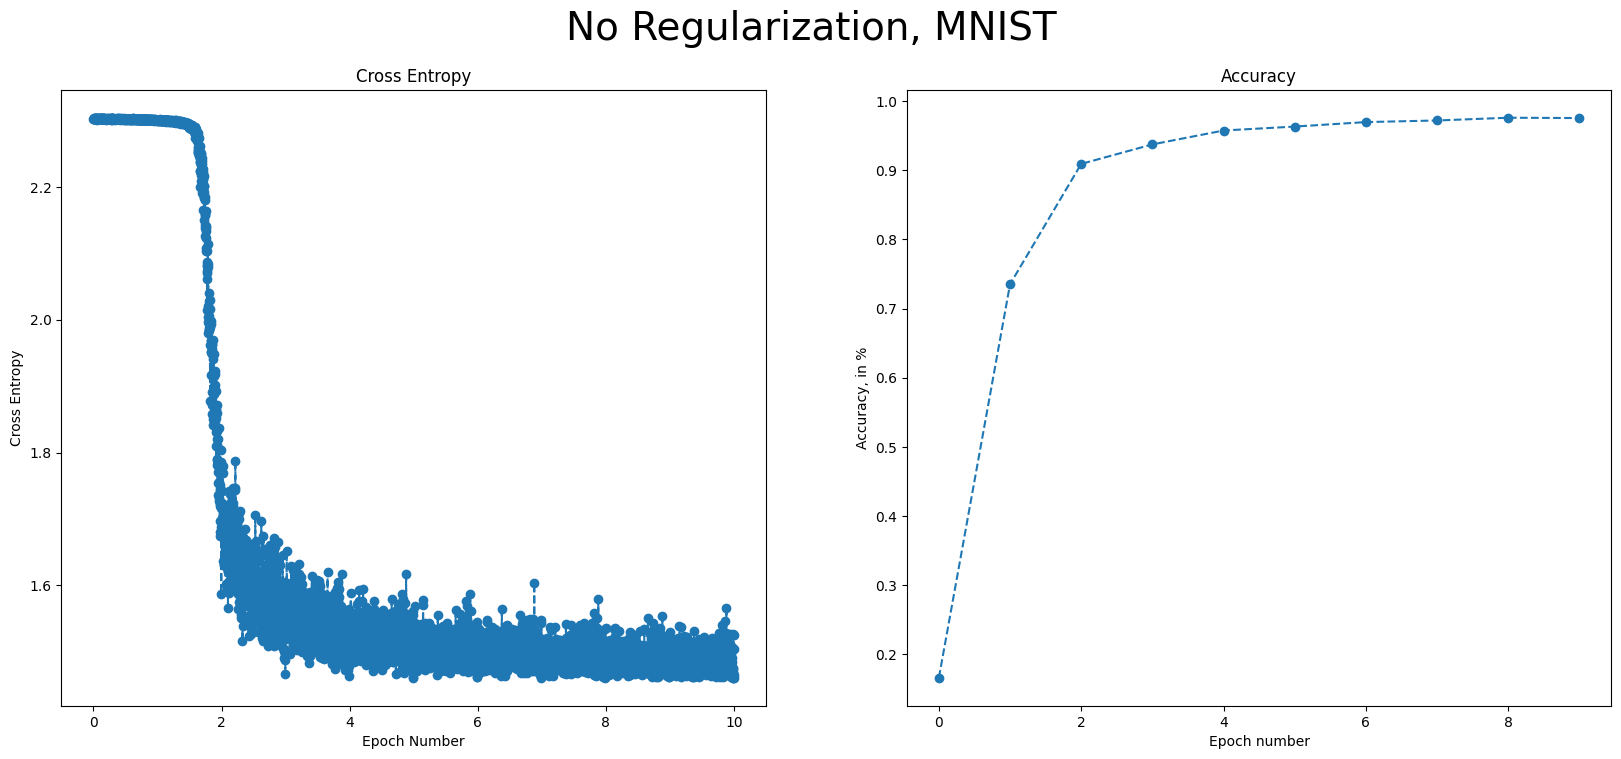

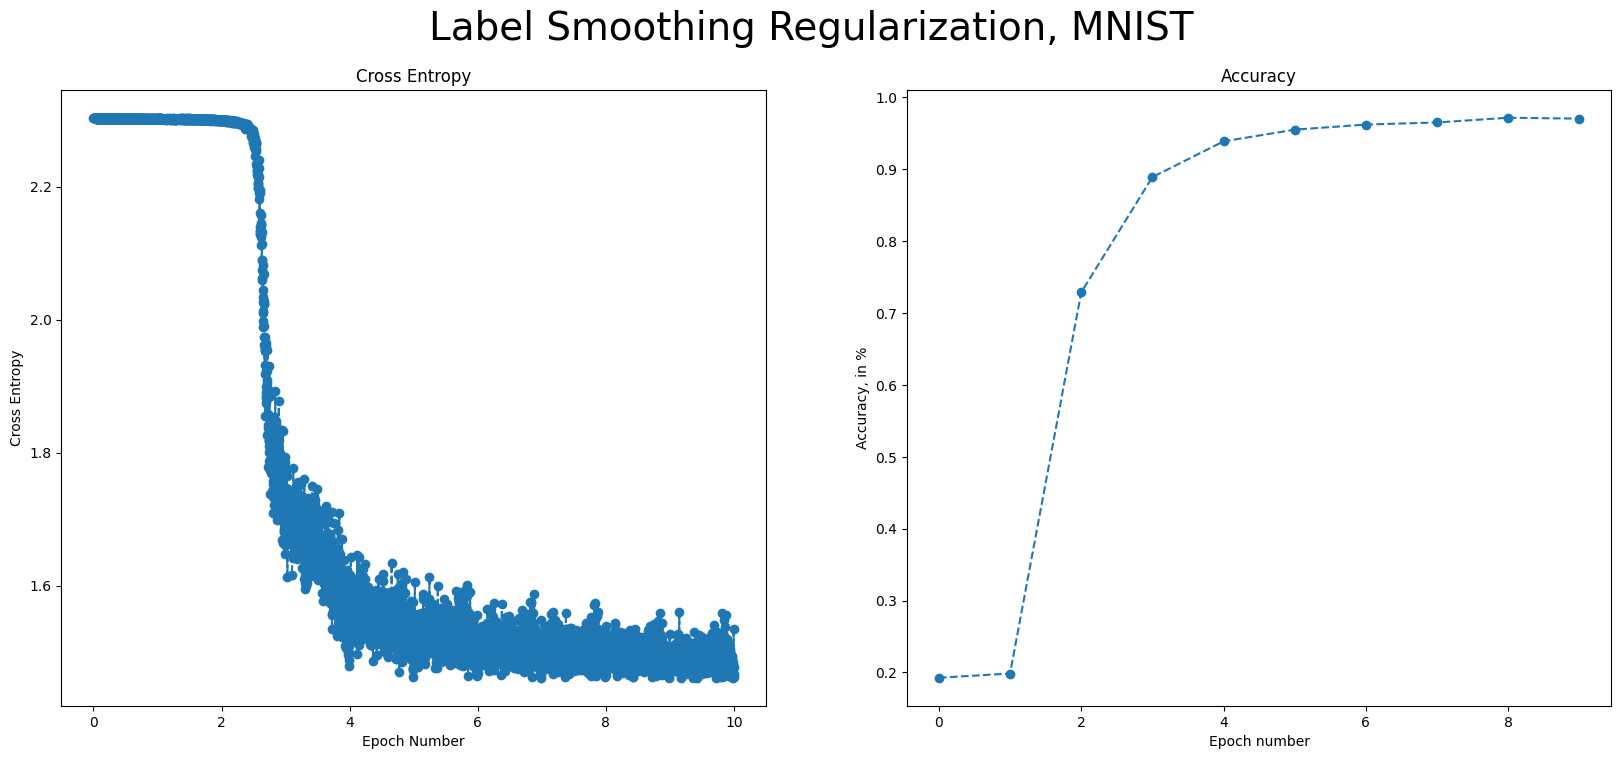

In [11]:
plot_results(epochs1, losses1, accuracies1, title="No Regularization, MNIST")
plot_results(
    epochs2, losses2, accuracies2, title="Label Smoothing Regularization, MNIST"
)

### Training CIFAR10 Models

In [12]:
in_channels = 3

In [13]:
model_no_reg_CIFAR10 = LeNet(
    lr=lr, momentum=momentum, in_channels=in_channels, orthogonal=False
).to(device)
model_label_smoothing_CIFAR10 = LeNet(
    lr=lr, momentum=momentum, in_channels=in_channels, orthogonal=False
).to(device)

In [14]:
n_epochs = 10

In [15]:
losses3, reg_losses3, epochs3, weights3, accuracies3 = train(
    train_loader_CIFAR10, test_loader_CIFAR10, model_no_reg_CIFAR10, n_epochs
)

Epoch: 0
Accuracy of the network on the test images: 14 %
Epoch: 1
Accuracy of the network on the test images: 28 %
Epoch: 2
Accuracy of the network on the test images: 32 %
Epoch: 3
Accuracy of the network on the test images: 39 %
Epoch: 4
Accuracy of the network on the test images: 43 %
Epoch: 5
Accuracy of the network on the test images: 44 %
Epoch: 6
Accuracy of the network on the test images: 44 %
Epoch: 7
Accuracy of the network on the test images: 46 %
Epoch: 8
Accuracy of the network on the test images: 46 %
Epoch: 9
Accuracy of the network on the test images: 49 %


In [20]:
losses4, reg_losses4, epochs4, weights4, accuracies4 = train(
    train_loader_CIFAR10,
    test_loader_CIFAR10,
    model_label_smoothing_CIFAR10,
    n_epochs,
    label_smoothing=True,
    label_smoothing_lmbd=0.00000001,
)

Epoch: 0
Accuracy of the network on the test images: 20 %
Epoch: 1
Accuracy of the network on the test images: 22 %
Epoch: 2
Accuracy of the network on the test images: 22 %
Epoch: 3
Accuracy of the network on the test images: 22 %
Epoch: 4
Accuracy of the network on the test images: 28 %
Epoch: 5
Accuracy of the network on the test images: 29 %
Epoch: 6
Accuracy of the network on the test images: 29 %
Epoch: 7
Accuracy of the network on the test images: 29 %
Epoch: 8
Accuracy of the network on the test images: 29 %
Epoch: 9
Accuracy of the network on the test images: 29 %


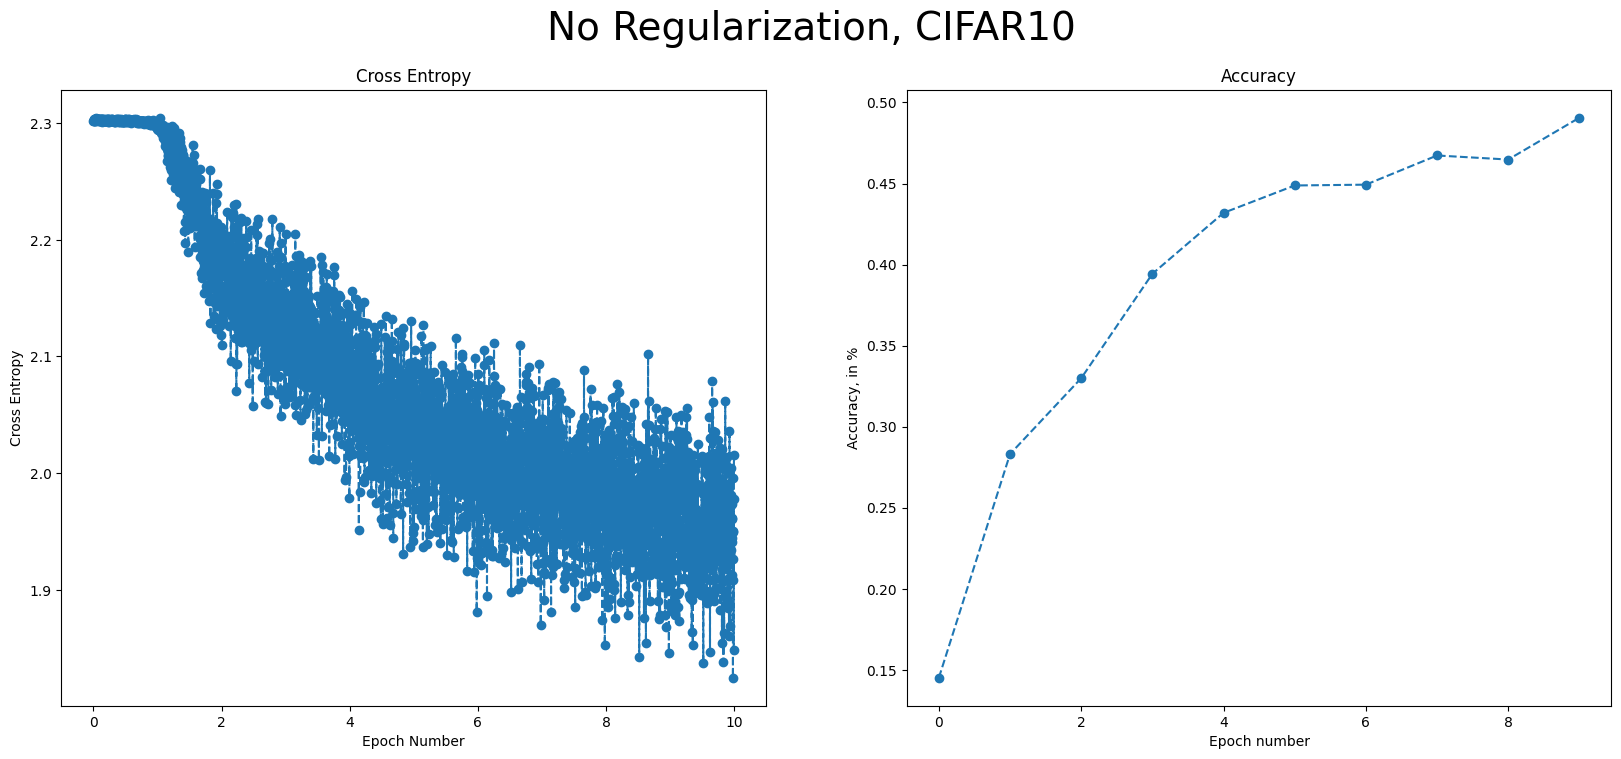

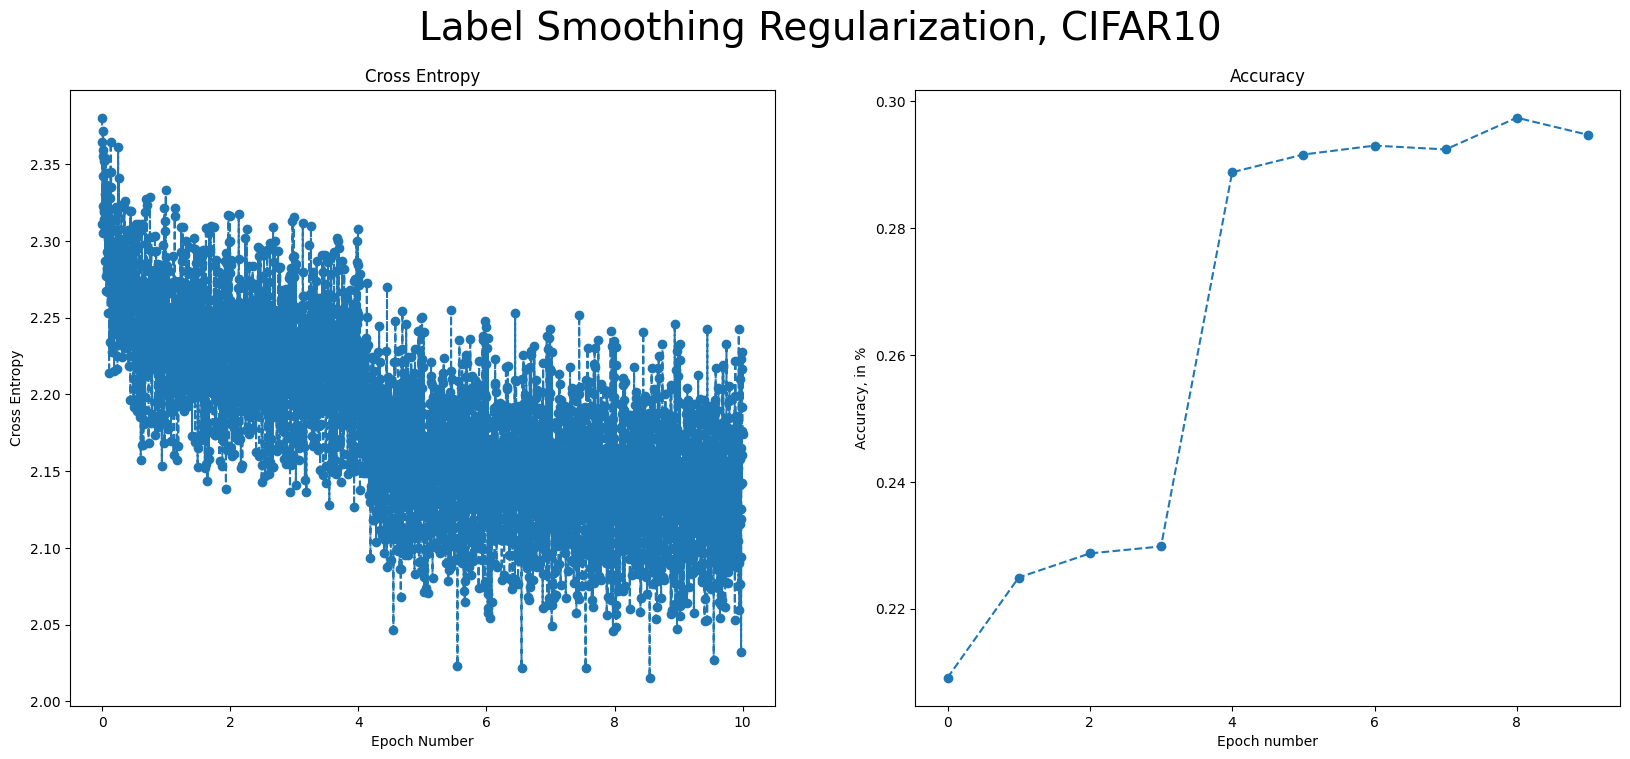

In [21]:
plot_results(epochs3, losses3, accuracies3, title="No Regularization, CIFAR10")
plot_results(
    epochs4, losses4, accuracies4, title="Label Smoothing Regularization, CIFAR10"
)

### Training CIFAR100 Models

In [6]:
in_channels = 3

In [7]:
model_no_reg_CIFAR100 = LeNet_100(
    lr=lr, momentum=momentum, in_channels=in_channels, orthogonal=False
).to(device)
model_label_smoothing_CIFAR100 = LeNet_100(
    lr=lr, momentum=momentum, in_channels=in_channels, orthogonal=False
).to(device)

In [8]:
n_epochs = 10

In [9]:
losses5, reg_losses5, epochs5, weights5, accuracies5 = train(
    train_loader_CIFAR100, test_loader_CIFAR100, model_no_reg_CIFAR100, n_epochs
)

Epoch: 0
Accuracy of the network on the test images: 1 %
Epoch: 1
Accuracy of the network on the test images: 1 %
Epoch: 2
Accuracy of the network on the test images: 1 %
Epoch: 3
Accuracy of the network on the test images: 1 %
Epoch: 4
Accuracy of the network on the test images: 1 %
Epoch: 5
Accuracy of the network on the test images: 1 %
Epoch: 6
Accuracy of the network on the test images: 1 %
Epoch: 7
Accuracy of the network on the test images: 1 %
Epoch: 8
Accuracy of the network on the test images: 1 %
Epoch: 9
Accuracy of the network on the test images: 1 %


In [10]:
losses6, reg_losses6, epochs6, weights6, accuracies6 = train(
    train_loader_CIFAR100,
    test_loader_CIFAR100,
    model_label_smoothing_CIFAR100,
    n_epochs,
    label_smoothing=True,
    label_smoothing_lmbd=0.000001,
)

Epoch: 0
Accuracy of the network on the test images: 0 %
Epoch: 1
Accuracy of the network on the test images: 0 %
Epoch: 2
Accuracy of the network on the test images: 0 %
Epoch: 3
Accuracy of the network on the test images: 0 %
Epoch: 4
Accuracy of the network on the test images: 0 %
Epoch: 5
Accuracy of the network on the test images: 0 %
Epoch: 6
Accuracy of the network on the test images: 0 %
Epoch: 7
Accuracy of the network on the test images: 0 %
Epoch: 8
Accuracy of the network on the test images: 0 %
Epoch: 9
Accuracy of the network on the test images: 0 %


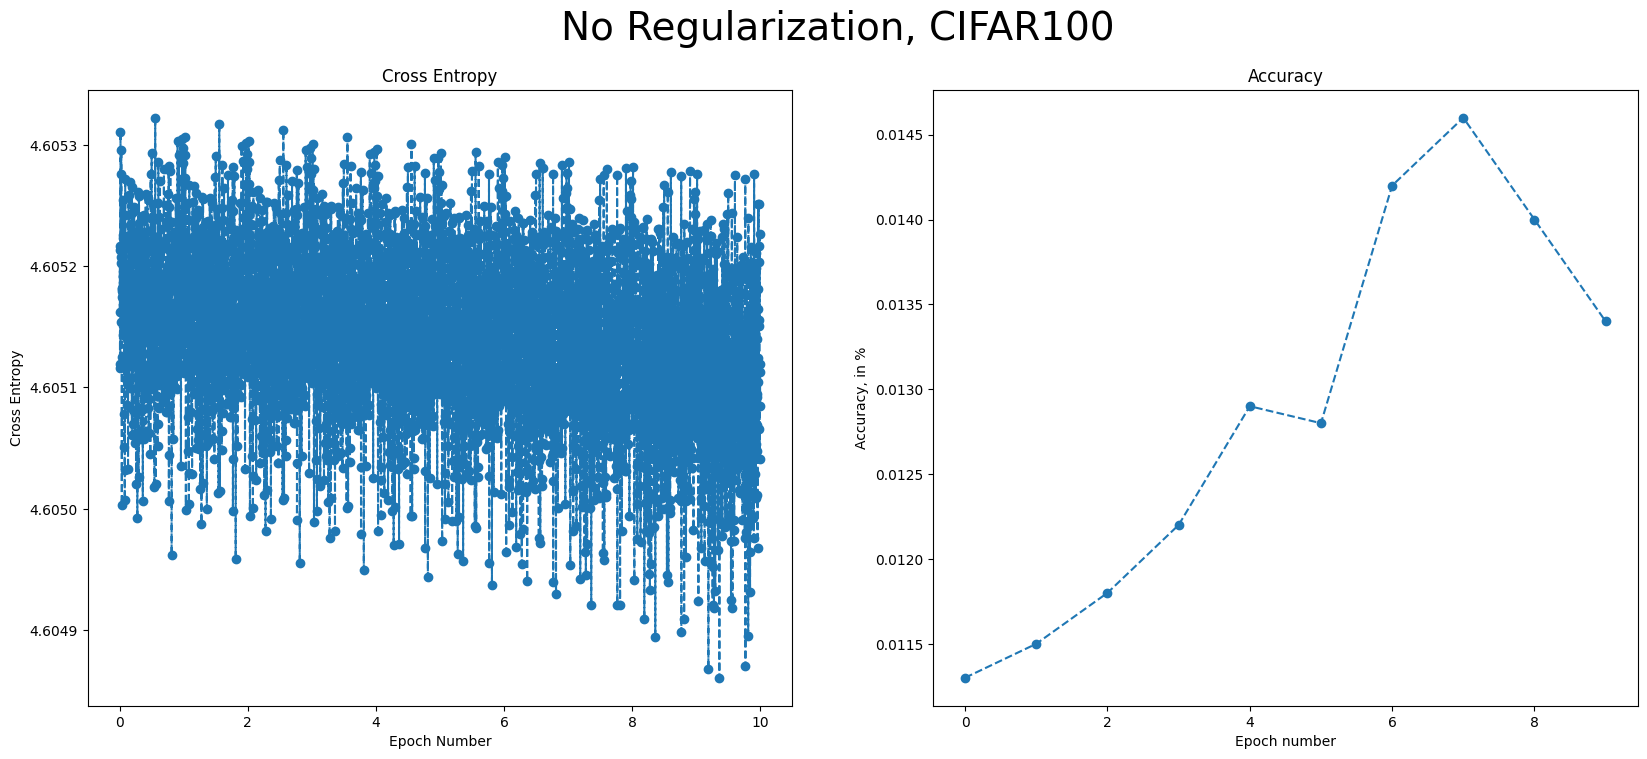

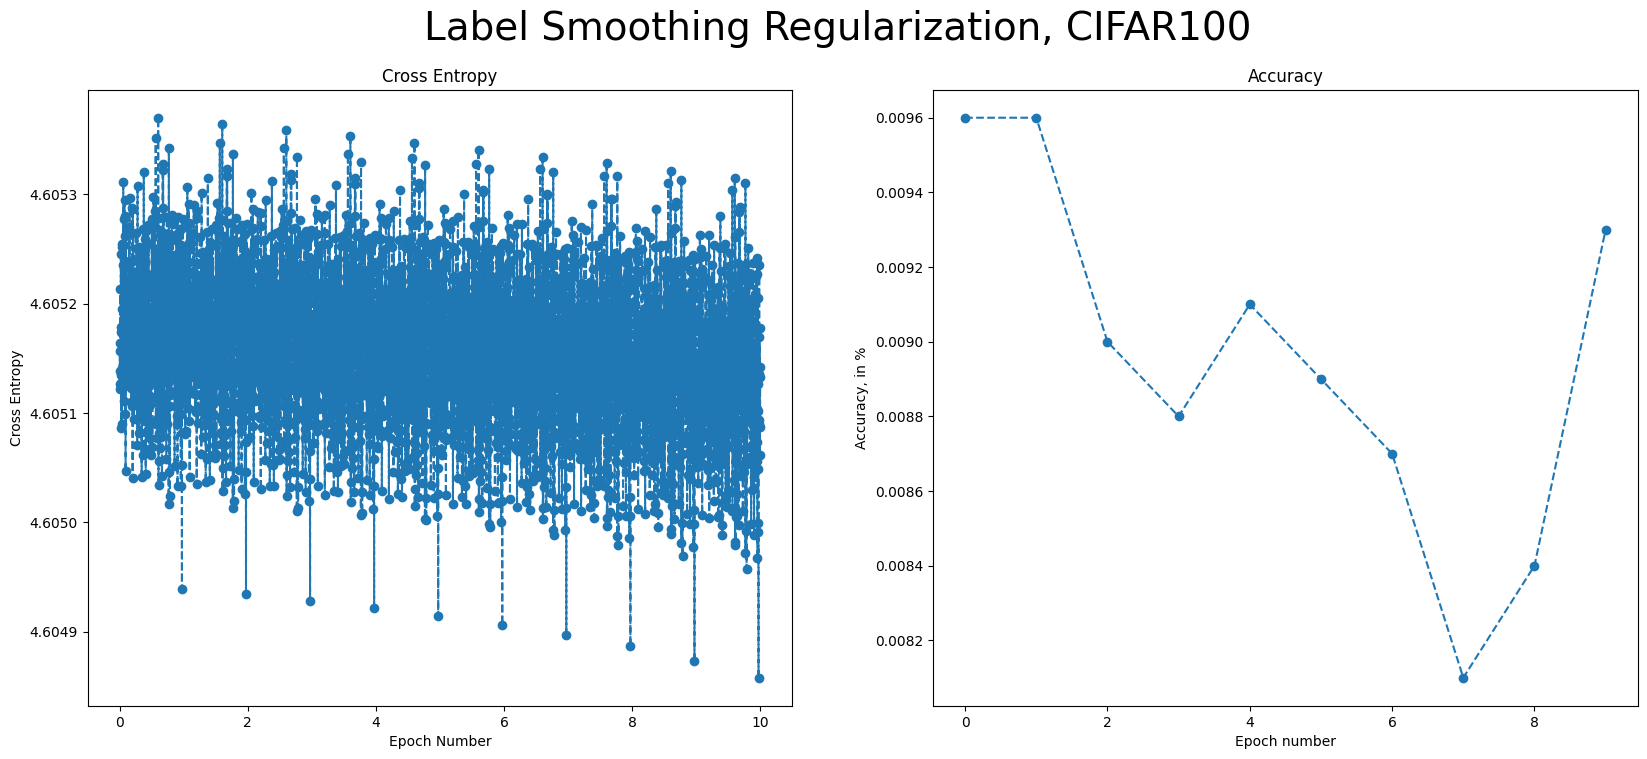

In [11]:
plot_results(epochs5, losses5, accuracies5, title="No Regularization, CIFAR100")
plot_results(
    epochs6, losses6, accuracies6, title="Label Smoothing Regularization, CIFAR100"
)

## Visualization of Label Smoothing

### Visualization Functions

In [12]:
# Function to extract penultimate layer activations
def extract_penultimate_activations(model, data_loader, class_ids, fraction=1.0):
    num_batches = int(len(data_loader) * fraction)
    activations = []
    labels = []

    for i, (data_batch, label_batch) in tqdm(enumerate(data_loader)):
        if i >= num_batches:
            break

        for data, label in zip(data_batch, label_batch):
            if label.item() in class_ids:
                data = data.unsqueeze(0).to(device)
                with torch.no_grad():
                    x = model.dropout1(
                        F.relu(
                            model.fc1(
                                model.pool(
                                    F.relu(
                                        model.conv2(
                                            model.pool(F.relu(model.conv1(data)))
                                        )
                                    )
                                ).view(-1, 16 * 5 * 5)
                            )
                        )
                    )
                    x = model.dropout2(F.relu(model.fc2(x)))
                activations.append(x.cpu().numpy().flatten())
                labels.append(label.item())

    return np.vstack(activations), labels

In [13]:
# Function to compute 2D projections of activations and templates
def compute_2d_projections(activations, templates):
    # Orthonormal basis of the plane crossing the templates of the three classes
    u, s, vh = np.linalg.svd(templates)
    basis = vh[:2, :]

    # Project the penultimate layer activations of examples from these three classes onto this plane
    projections = np.dot(activations, basis.T)
    template_projections = np.dot(templates, basis.T)

    return projections, template_projections

In [14]:
# Function to plot 2D projections
def plot_2d_projections(ax, projections, labels, template_projections, title):
    colors = ["r", "g", "b"]
    markers = ["o", "^", "s"]

    for idx, (proj, label) in enumerate(zip(projections, labels)):
        ax.scatter(
            proj[0], proj[1], color=colors[label], marker=markers[label], alpha=0.7
        )

    for idx, template_proj in enumerate(template_projections):
        ax.scatter(
            template_proj[0],
            template_proj[1],
            color=colors[idx],
            marker=markers[idx],
            edgecolors="k",
            s=150,
            linewidths=2,
            label=f"Class {class_ids[idx]}",
        )

    ax.set_xlabel("First basis vector")
    ax.set_ylabel("Second basis vector")
    ax.legend()
    ax.set_title(title)

In [15]:
def plot_label_smoothing_2d_projections(
    model,
    train_loader,
    test_loader,
    class_ids,
    train_title,
    test_title,
    sup_title,
    fraction=1.0,
):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot training data
    activations, labels = extract_penultimate_activations(
        model, train_loader, class_ids, fraction
    )
    templates = model.fc3.weight[class_ids, :].detach().cpu().numpy()
    projections, template_projections = compute_2d_projections(activations, templates)
    plot_2d_projections(ax1, projections, labels, template_projections, train_title)

    # Plot test data
    activations, labels = extract_penultimate_activations(model, test_loader, class_ids)
    templates = model.fc3.weight[class_ids, :].detach().cpu().numpy()
    projections, template_projections = compute_2d_projections(activations, templates)
    plot_2d_projections(ax2, projections, labels, template_projections, test_title)

    # Add overarching title
    fig.suptitle(sup_title, fontsize=30, y=1.05)

    # Adjust layout to prevent overlapping of titles and labels
    plt.tight_layout()
    plt.show()

### MNIST Visualization

In [35]:
# Pick three classes
class_ids = [0, 1, 2]

93it [00:05, 16.09it/s]
79it [00:03, 22.33it/s]


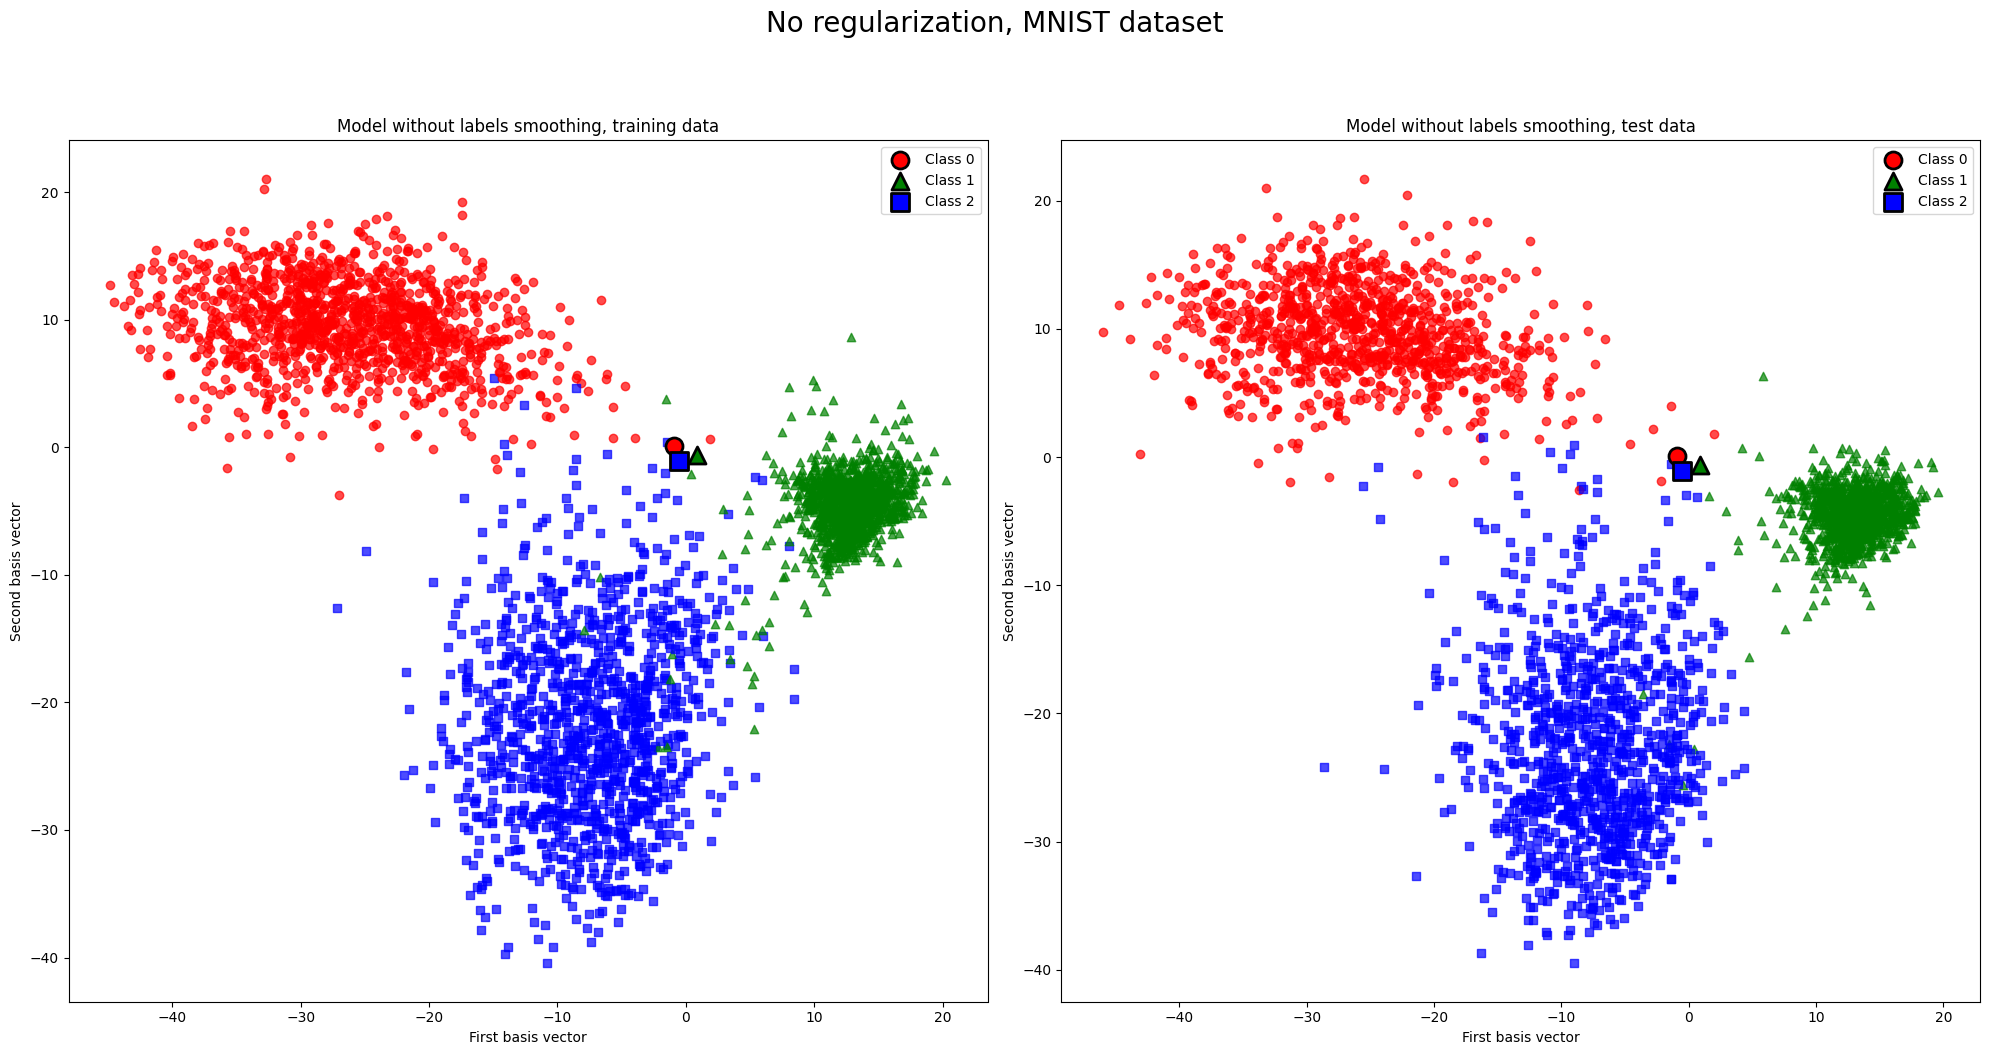

In [36]:
plot_label_smoothing_2d_projections(
    model_no_reg_MNIST,
    train_loader_MNIST,
    test_loader_MNIST,
    class_ids,
    train_title="Model without labels smoothing, training data",
    test_title="Model without labels smoothing, test data",
    sup_title="No regularization, MNIST dataset",
    fraction=0.2,
)

93it [00:03, 25.90it/s]
79it [00:03, 21.90it/s]


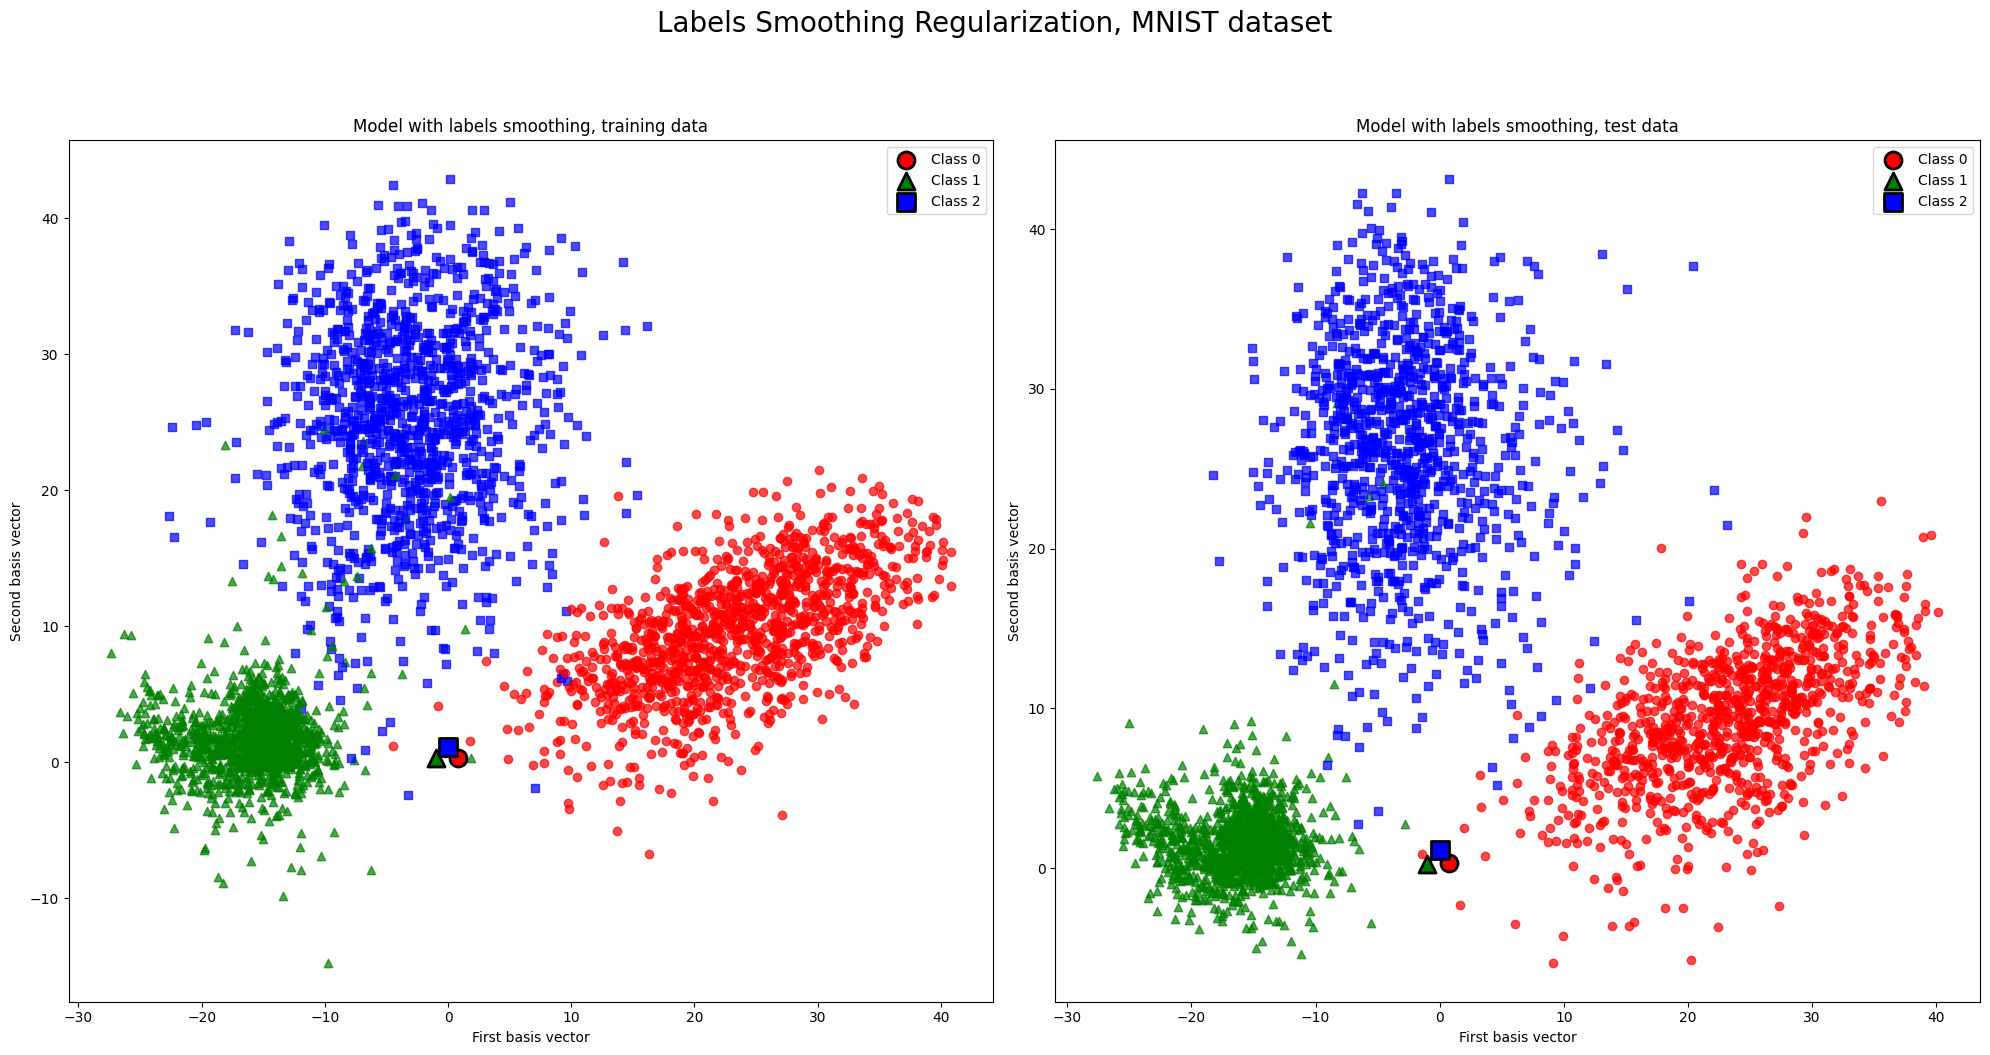

In [37]:
plot_label_smoothing_2d_projections(
    model_label_smoothing_MNIST,
    train_loader_MNIST,
    test_loader_MNIST,
    class_ids,
    train_title="Model with labels smoothing, training data",
    test_title="Model with labels smoothing, test data",
    sup_title="Labels Smoothing Regularization, MNIST dataset",
    fraction=0.2,
)

### CIFAR10 Visualization

In [38]:
# Pick three classes
class_ids = [0, 1, 2]

78it [00:01, 43.90it/s]
79it [00:02, 38.70it/s]


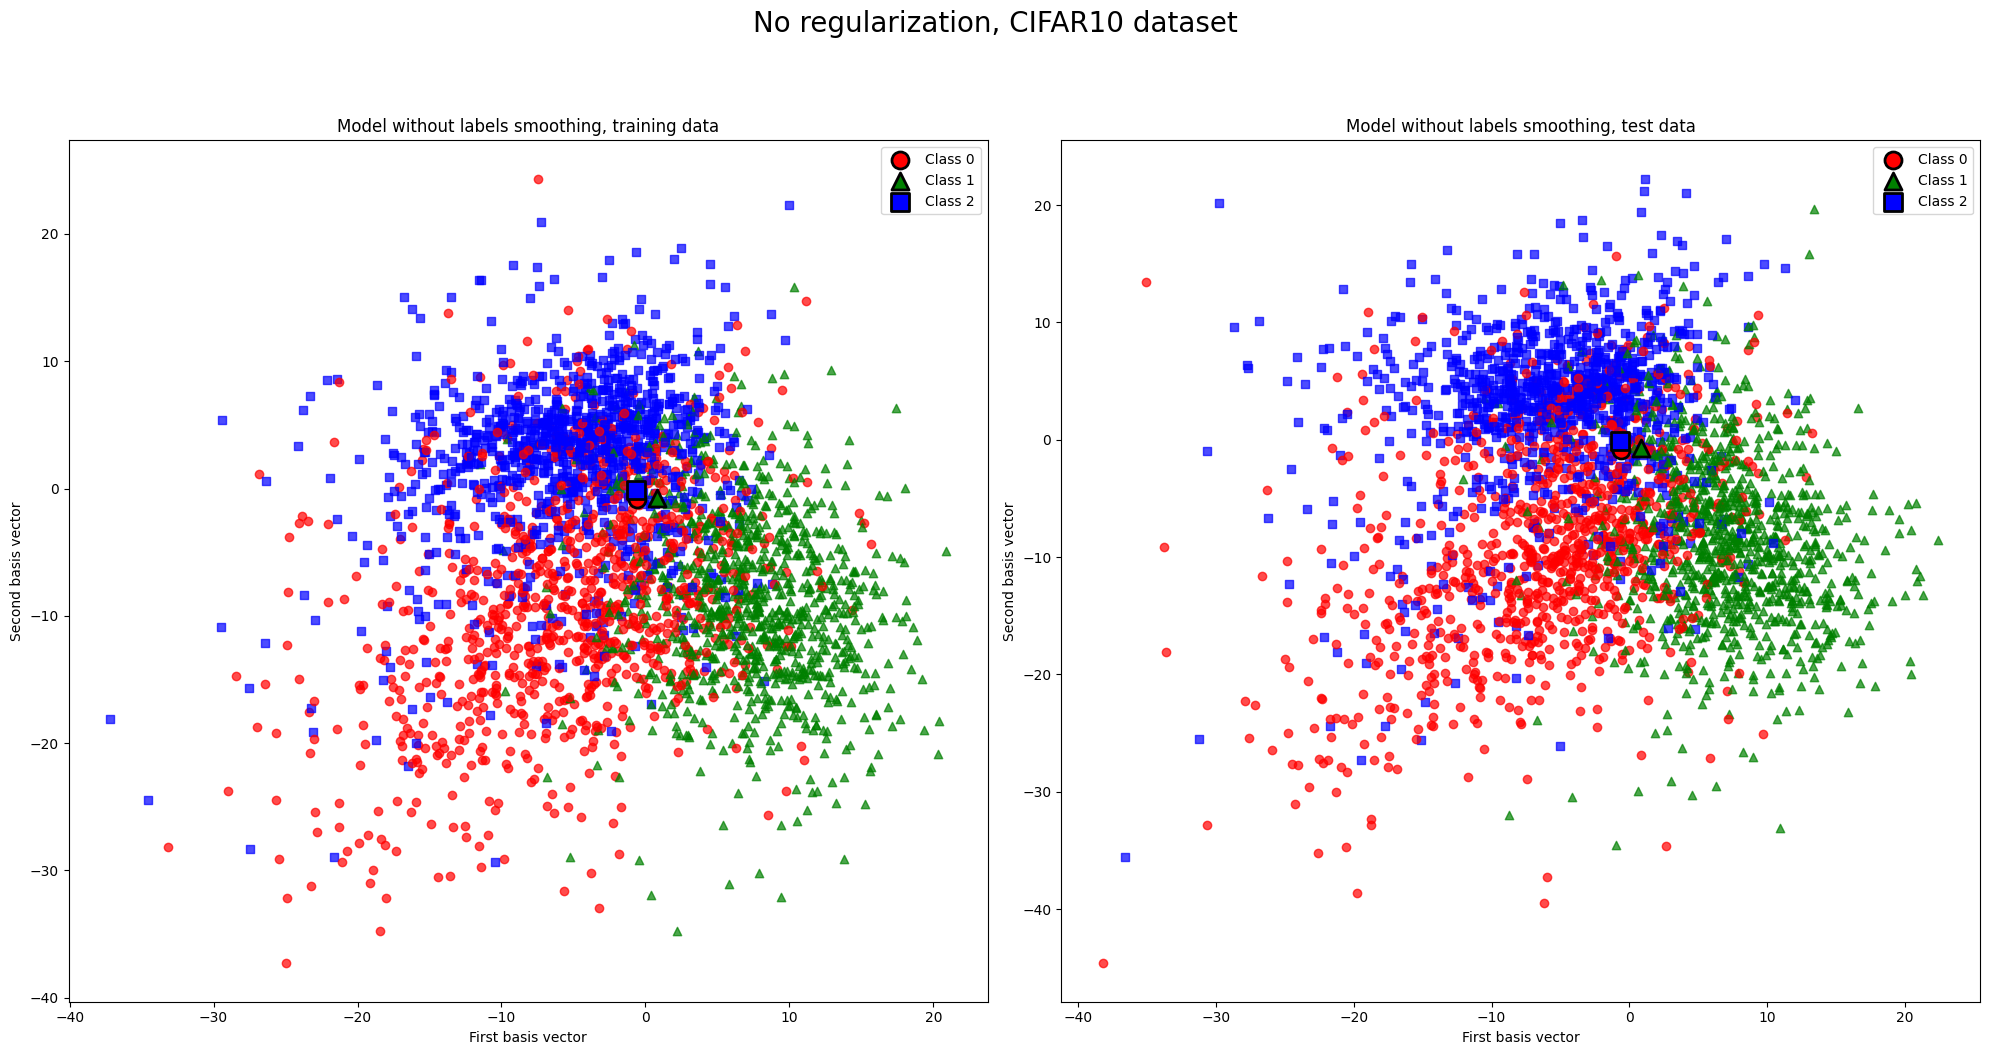

In [39]:
plot_label_smoothing_2d_projections(
    model_no_reg_CIFAR10,
    train_loader_CIFAR10,
    test_loader_CIFAR10,
    class_ids,
    train_title="Model without labels smoothing, training data",
    test_title="Model without labels smoothing, test data",
    sup_title="No regularization, CIFAR10 dataset",
    fraction=0.2,
)

78it [00:01, 46.21it/s]
79it [00:01, 41.32it/s]


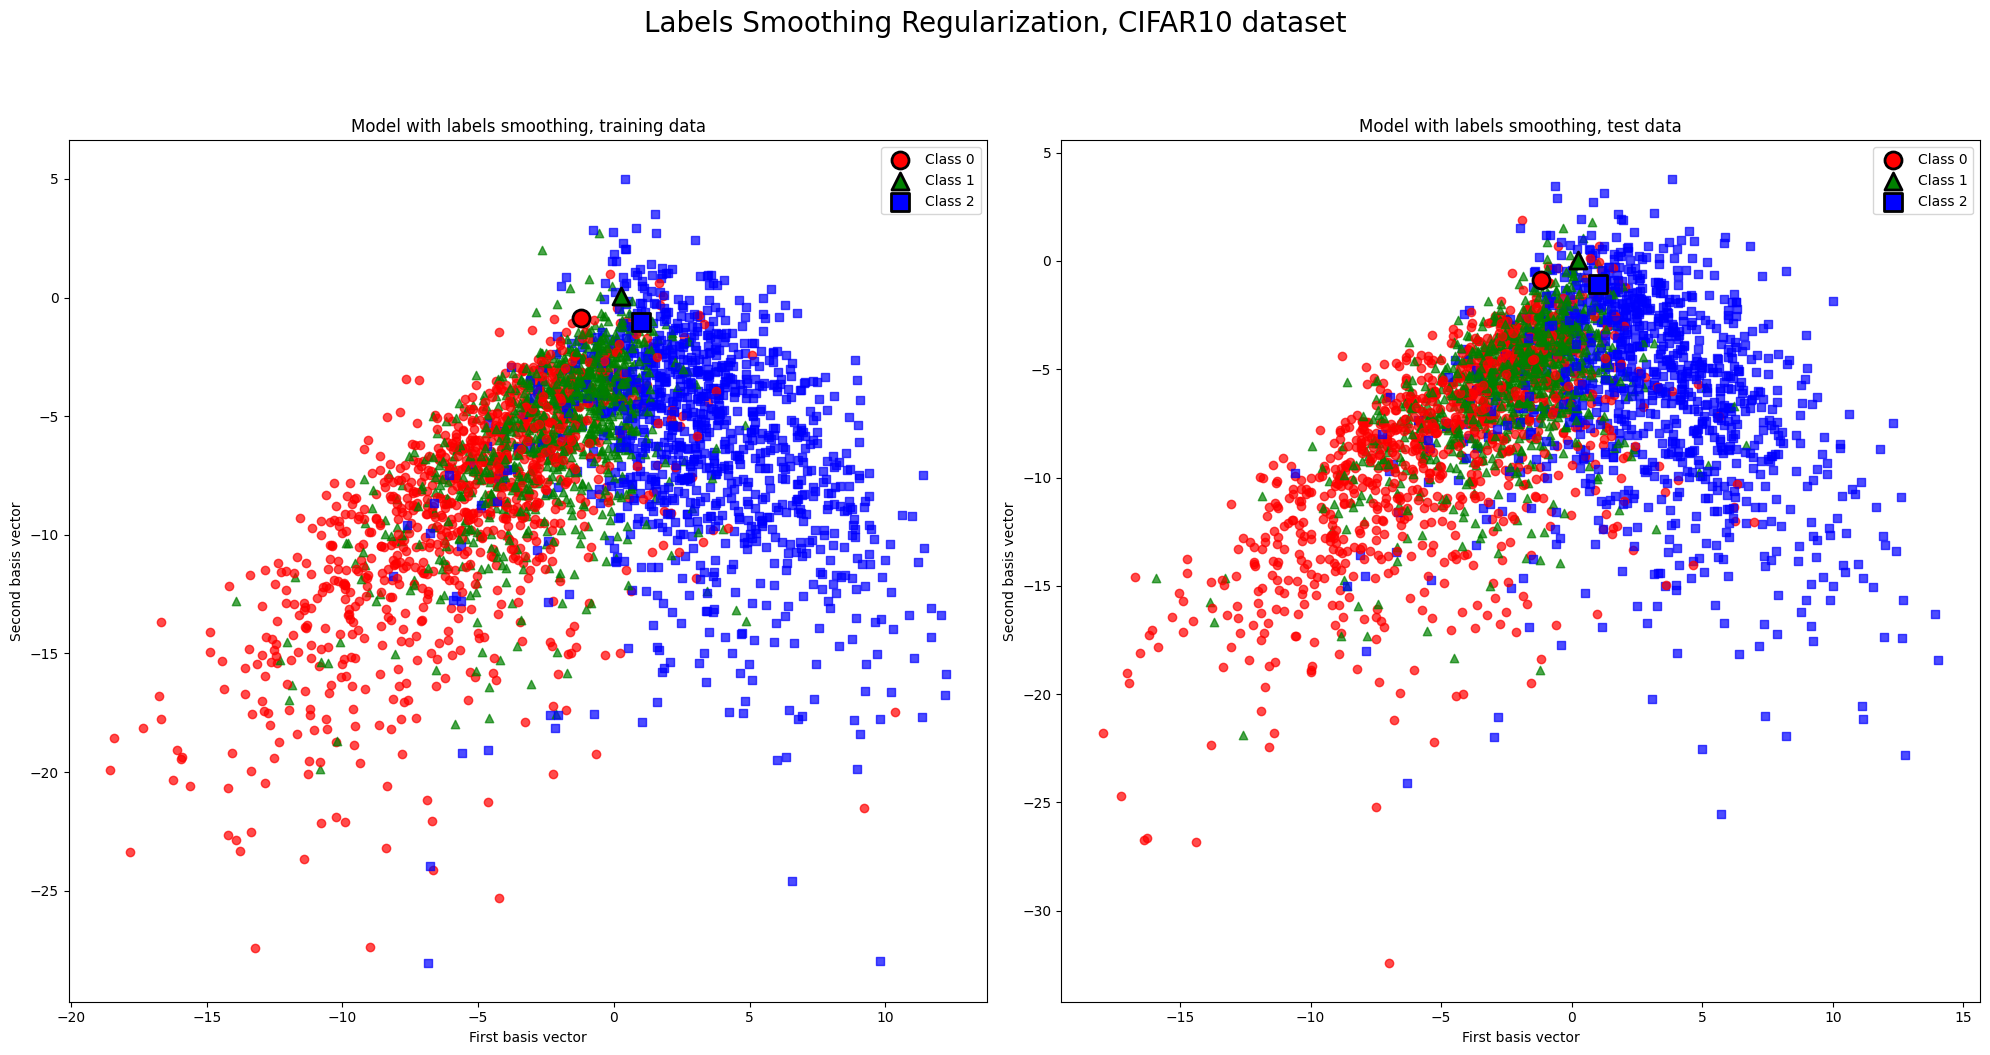

In [40]:
plot_label_smoothing_2d_projections(
    model_label_smoothing_CIFAR10,
    train_loader_CIFAR10,
    test_loader_CIFAR10,
    class_ids,
    train_title="Model with labels smoothing, training data",
    test_title="Model with labels smoothing, test data",
    sup_title="Labels Smoothing Regularization, CIFAR10 dataset",
    fraction=0.2,
)

### CIFAR100 Visualization

In [16]:
# Pick three classes
class_ids = [0, 1, 2]

78it [00:01, 55.90it/s]
79it [00:01, 49.64it/s]


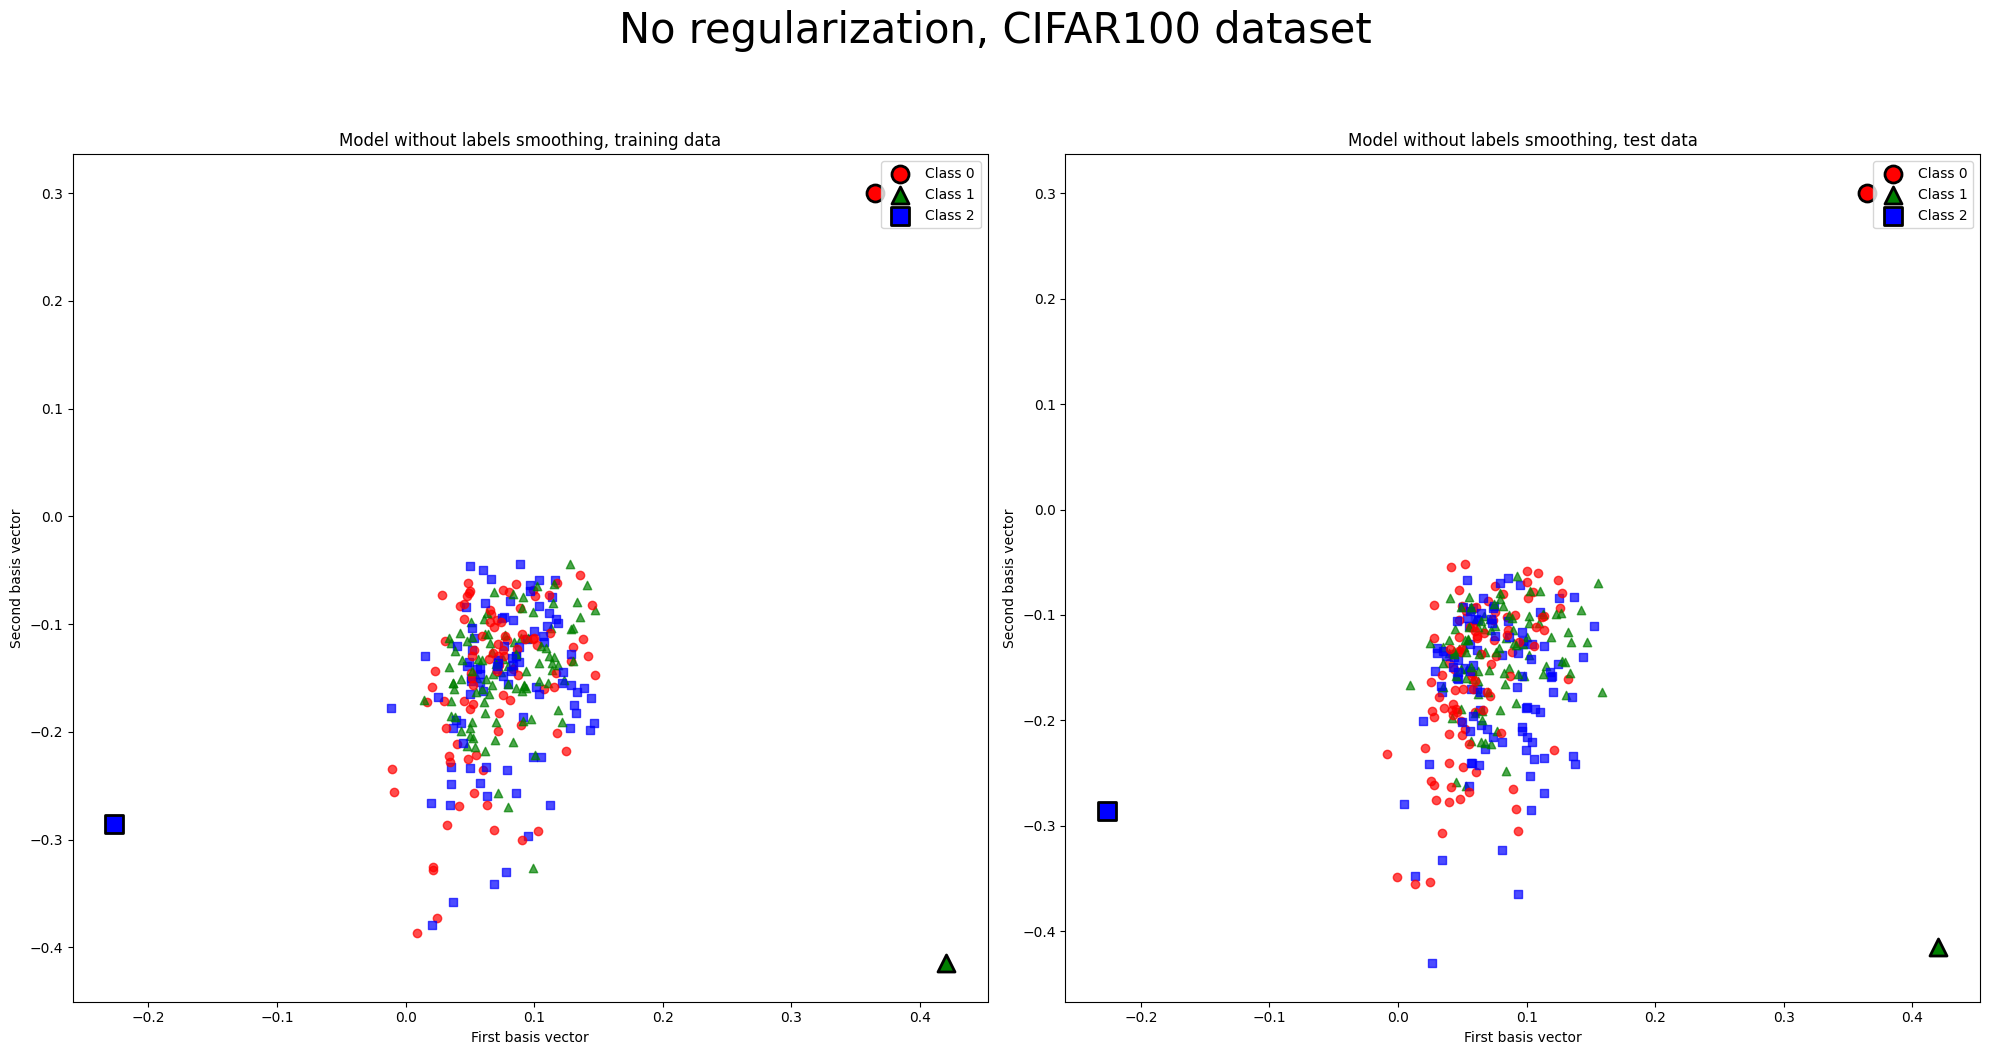

In [17]:
plot_label_smoothing_2d_projections(
    model_no_reg_CIFAR100,
    train_loader_CIFAR100,
    test_loader_CIFAR100,
    class_ids,
    train_title="Model without labels smoothing, training data",
    test_title="Model without labels smoothing, test data",
    sup_title="No regularization, CIFAR100 dataset",
    fraction=0.2,
)

78it [00:01, 59.29it/s]
79it [00:01, 47.69it/s]


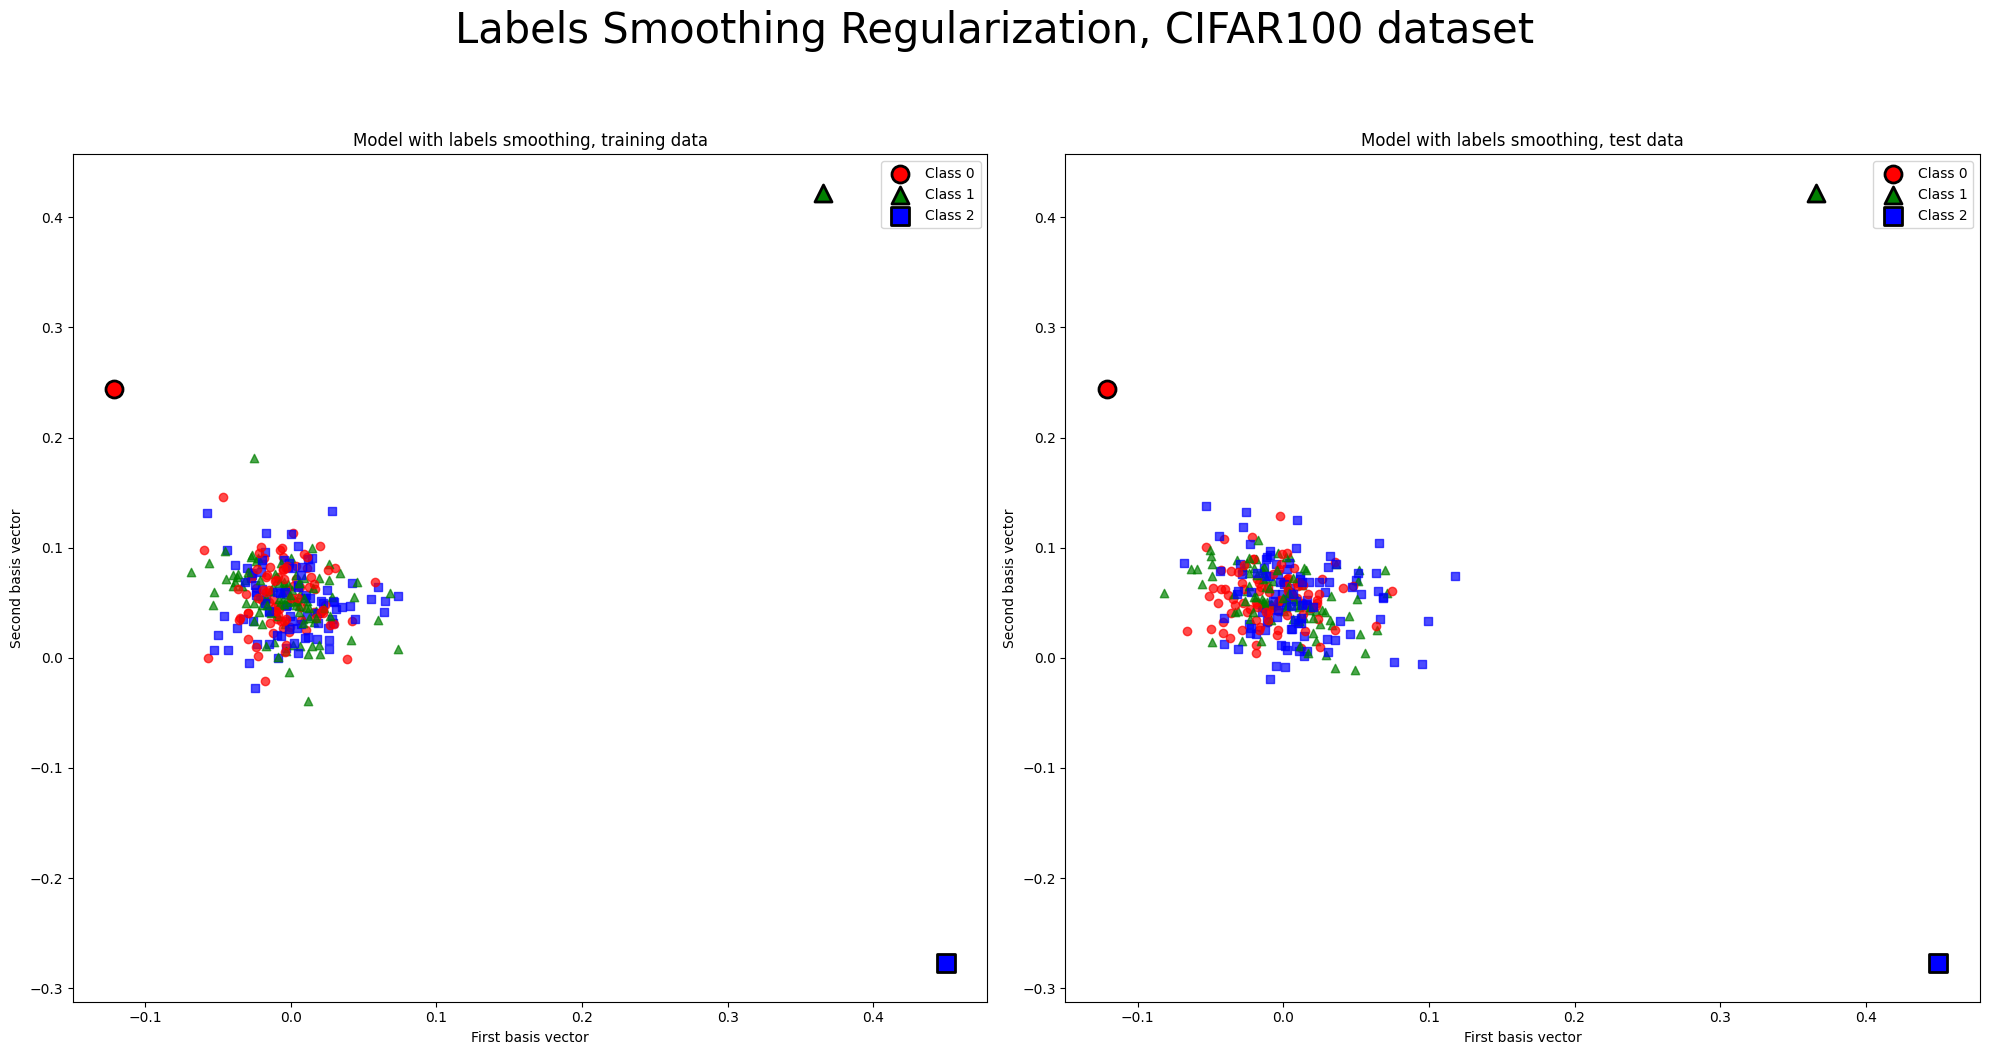

In [18]:
plot_label_smoothing_2d_projections(
    model_label_smoothing_CIFAR100,
    train_loader_CIFAR100,
    test_loader_CIFAR100,
    class_ids,
    train_title="Model with labels smoothing, training data",
    test_title="Model with labels smoothing, test data",
    sup_title="Labels Smoothing Regularization, CIFAR100 dataset",
    fraction=0.2,
)